# Credit Card Customer Segmentation

In this project, we’ll assume we are working for a credit card company. The dataset contains information about the company’s clients and we're asked to help segment them into different groups in order to apply different business strategies for each type of customer. 

For instance, the company could provide higher credit limits for customers that use the card a lot, but spend little money, or even create incentives for those with high income who don't use the card as much as the company expects. In order to apply different strategies, the company needs different groups of customers. We will use the K-means algorithm for this.

We will go through the following steps:

- Analyze the dataset;
- Prepare the data for modeling;
- Find an appropriate number of clusters;
- Segment the data;
- Interpret and explain the results.

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

customers = pd.read_csv('customer_segmentation.csv')

In [2]:
# Exploring the data

print("Dataset information")
print(customers.info())
print('\n')
print("Head data:")
print(customers.head())

# Descriptive statistics
num_vars = customers.columns[customers.dtypes != 'object']
print("Numerical vars descriptives:")
print(customers[num_vars].describe())

cat_vars = customers.columns[customers.dtypes == 'object']
print("Categorical vars descriptives:")
print(customers[cat_vars].describe())

# Missings?
print("Numerical vars missings:")
print(customers[num_vars].isnull().sum().sort_values(ascending=False) / len(customers))
print('\n')
print("Categorical vars missings:")
print(customers[cat_vars].isnull().sum().sort_values(ascending=False) / len(customers))

Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null 

The dataset has been cleaned insofar as there are no recorded missing values. We have N=10127 cases at our disposal. Of the 11 numerical variables, the `customer_id` variable cannot be used for our analysis. We also have 3 categorical variables (gender, education and marital status) that can enter the analysis as dummy variables.

Let's recode the categorical variables as dummies and take a look at some correlations

In [3]:
# Code categorical variables as dummies

customers_updated = pd.get_dummies(data=customers, columns=['gender', 'education_level', 'marital_status'], drop_first=False, dtype='int')

# Deleting customer_id from this DataFrame

customers_updated = customers_updated.iloc[:, 1:] 

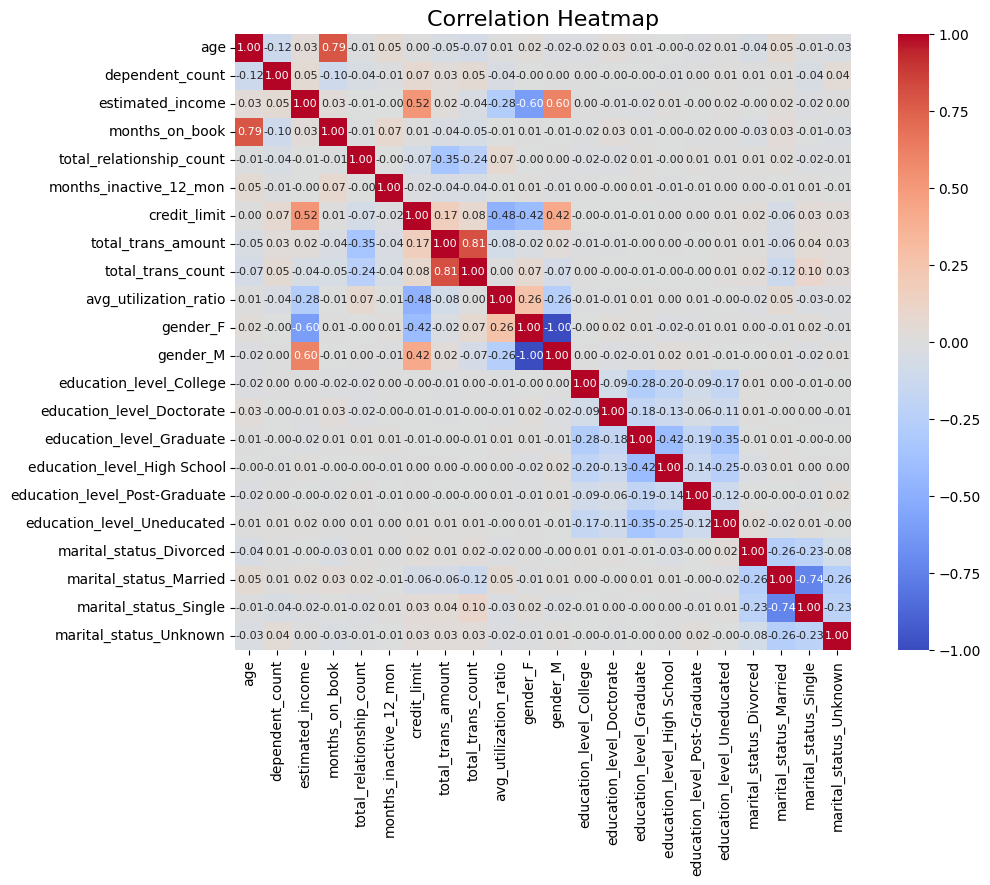

In [4]:
# Calculate correlations

correlations = customers_updated.corr()
#print(correlations)

# Heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

The heatmap reveals some interesting correlations. Expectedly, the length of the time that someone has been a customer correlates strongly with age (r=.79), the credit limit is also (not surprisingly) higher for people with a higher estimated income (r=.52). Also, customers that make more transactions (`total_trans_count`) will tend to have higher total transaction amounts (`total_trans_amount`) (r=.81). An interesting observation is that customers with higher transaction counts and higher total transaction amounts seem to be somewhat less likely to contact the company, as we find moderate negative correlations (r=-.24 / r=-.35) with `total_relationship_count`. A customers credit limit correlates negatively with the average utilization ratio (r=-.48), indicating that frequent credit card users tend to receive lower credit limit as they also tend to have lower incomes. The credit limit is positively correlated with male gender, wheras it's negativeky correlated with female gender. Furthermore, there's a positive correlation between the average utilization ratio and femae gender (r=.26).

Let's see if there are any particularly skewed variables that we should be aware of.

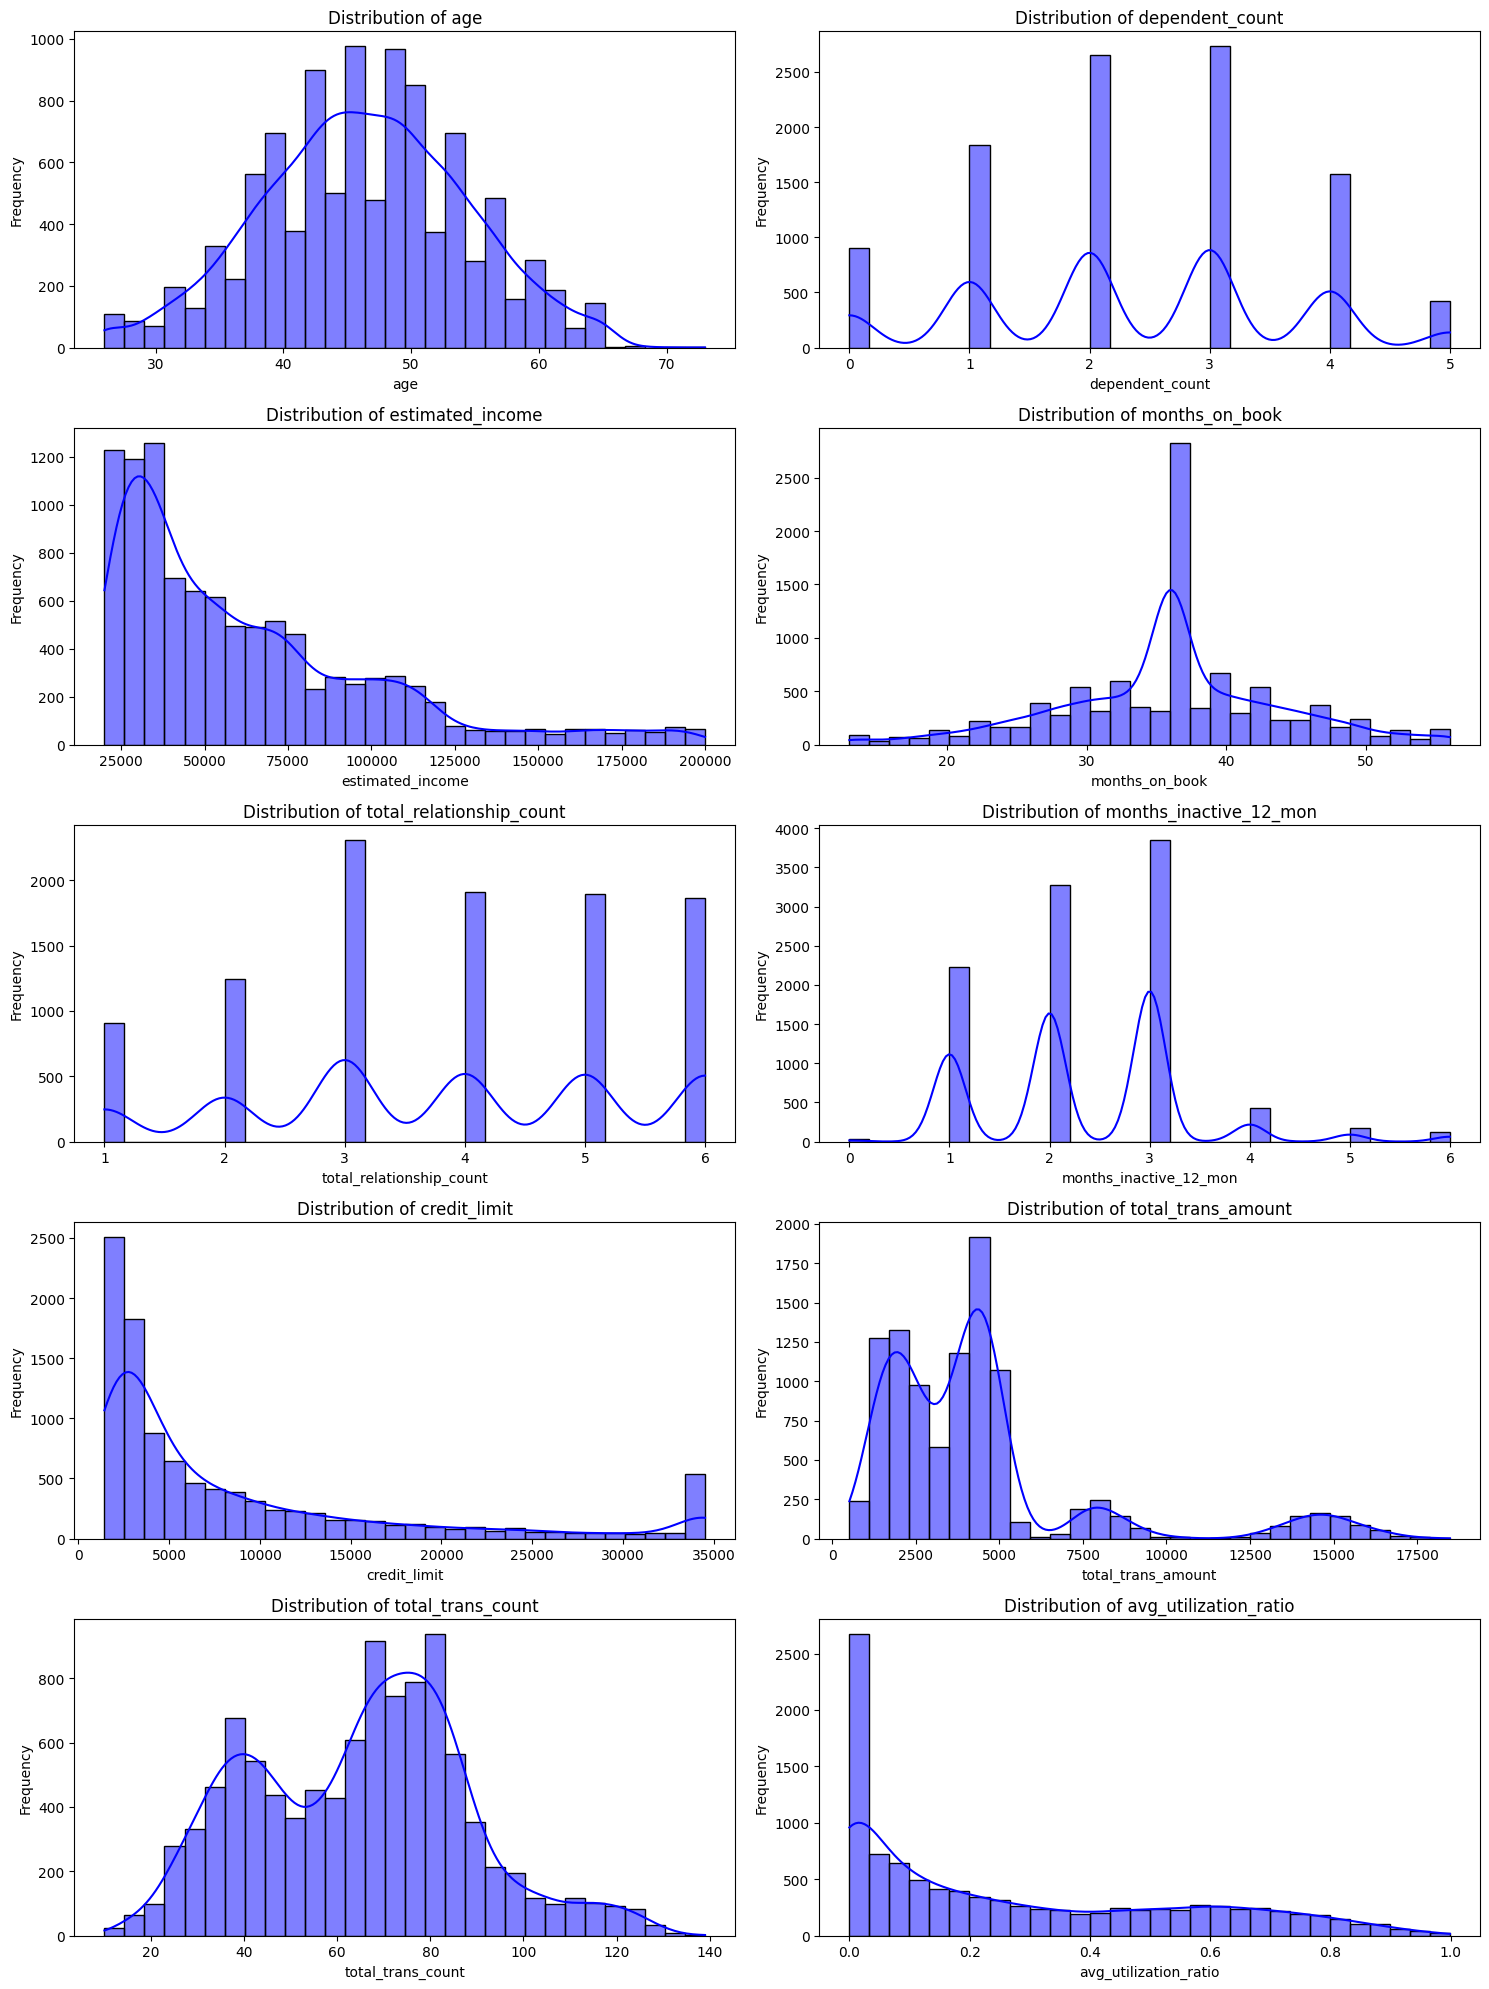

In [5]:
# Plot distributions of numerical variables

plt.figure(figsize=(15, 20))

for i, var in enumerate(num_vars[1:], 1): # disregarding customer_id
    plt.subplot(5, 2, i)  
    sns.histplot(customers_updated[var], kde=True, color='blue', bins=30)
    plt.title(f'Distribution of {var}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Most variables do not show too unexpected distributions, but there are some noteworthy observations. The variable `months_on_book` has an unexpected high number of cases at the 36 months mark. Maybe a high number of customers were acquired through a special promotion at that time? Another interesting case is the `credit_limit`. While the distributions is right-skewed like the income distirbution, there is an unexpectedly high amount of customers with a credit limit of ca. 34k. It's unclear why this group stands out in regard to the credit limit. 

From a segmentation point of view, the variables `total_trans_amount`and `total_trans_count` look interesting, as they seem to have multiple modes. With regard to the total transaction amount we can identify roughly three groups. The first group has a total transaction amount of up to ca. 7000 USD, the second group has transaction amounts between 7000 and 10000 USD. And there is a throd group with transaction amount between 12500 and 17500 USD. For the transaction counts we can roughly identify two overlapping segments. The first segment has a peak at about 40 transactions, the second peaks at about 80 transactions. So these seem to be groups of customers with different credit card use patterns. When it comes to the credit card utilization ratio, we see that there is a high share of people with low utilization, and hihger shares of utilization are spread out all over the spectrum with a slight peak at 0.65 utilization ratio.

For the categorical variables it should suffice to look at the frequency tables.

In [6]:
# Frequency tables of categorical variables

print(customers['gender'].value_counts(normalize=True))
print('\n')
print(customers['education_level'].value_counts(normalize=True))
print('\n')
print(customers['marital_status'].value_counts(normalize=True))

F    0.529081
M    0.470919
Name: gender, dtype: float64


Graduate         0.363879
High School      0.232152
Uneducated       0.173299
College          0.117705
Post-Graduate    0.060827
Doctorate        0.052138
Name: education_level, dtype: float64


Married     0.462822
Single      0.389355
Unknown     0.073961
Divorced    0.073862
Name: marital_status, dtype: float64


The gender distribution is balanced. We can see that in our sample up to 40% of the cases have an education level up to High School level, with the most frequent category being Graduate. Ca. 23% of customers have a College, Post-Graduate or Doctoral degree. About 46% of customers are married.

We can now go to the next step of feature engineering.

## Feature engineering

As the inspection of the education variable has revealed, it makes sense to treat it like an ordinal variable rather that assigining a dummy to each category. We can therefore create an analysis DataFrame which assigns 0 and 1 to the gender variable and applies a rank ordering to the education variable.

In [7]:
# Create analysis DataFrame

customers_modif = customers.copy()
customers_modif['gender'] = np.where(customers_modif['gender'] == 'M', 1, 0)  # Males = 1, Females = 0

print(customers_modif['gender'].value_counts())

# Mapping dictionary for education_level
dict_edu = {'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}

# Remap the values of education_level
customers_modif['education_level'] = customers_modif['education_level'].map(dict_edu)

print(customers_modif['education_level'].value_counts())

0    5358
1    4769
Name: gender, dtype: int64
3    3685
1    2351
0    1755
2    1192
4     616
5     528
Name: education_level, dtype: int64


We will use one-hot-encoding for the `marital_status`column.

In [8]:
# One-hot-encoding for marital_status, dropping reference category (divorced)

customers_modif = pd.get_dummies(data=customers_modif, columns=['marital_status'], drop_first=True, dtype='int')
#customers_modif = customers_modif.drop(['marital_status'], axis=1)
customers_modif

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,1,2,3,51000,40,3,2,4003.0,15476,117,0.462,0,1,0
10123,710638233,41,1,2,3,40000,25,4,2,4277.0,8764,69,0.511,0,0,0
10124,716506083,44,0,1,1,33000,36,5,3,5409.0,10291,60,0.000,1,0,0
10125,717406983,30,1,2,3,47000,36,4,3,5281.0,8395,62,0.000,0,0,1


We also drop `customer_id`from this DataFrame.

In [9]:
# Drop customer_id

customers_modif = customers_modif.iloc[:, 1:]

## Scaling the data

Since all the variables are measured on very different scales, we need to normalize them to a range between 0 and 1. We will use the `StandardScaler()`for this.

In [10]:
# Scaling the data

def scaler(df):
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled

customers_scaled = scaler(customers_modif)

customers_scaled

array([[-0.16540558,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [ 0.33357038, -0.9434357 ,  2.04319867, ..., -0.92821381,
         1.2523374 , -0.28260887],
       [ 0.58305837,  1.05995565,  0.50336813, ...,  1.07733799,
        -0.79850685, -0.28260887],
       ...,
       [-0.29014957, -0.9434357 , -1.03646242, ...,  1.07733799,
        -0.79850685, -0.28260887],
       [-2.03656544,  1.05995565, -0.26654715, ..., -0.92821381,
        -0.79850685,  3.53845931],
       [-0.41489356, -0.9434357 , -0.26654715, ...,  1.07733799,
        -0.79850685, -0.28260887]])

## Choosing the right number of K clusters

Now our dataset is ready for machine learning. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric.

We'll have to create several models and compute the inertia from each of them. Then, we'll be able to plot the Elbow Curve and decide the number of clusters we'll use to segment the customers. Once we do all that, we can perform the real clusterization.

Cluster 1, Inertia: 151905.0
Cluster 2, Inertia: 134790.35248443947
Cluster 3, Inertia: 123153.33571754492
Cluster 4, Inertia: 112890.90073324484
Cluster 5, Inertia: 104079.94123897493
Cluster 6, Inertia: 98723.34371687284
Cluster 7, Inertia: 94452.4991087993
Cluster 8, Inertia: 91000.7291910714
Cluster 9, Inertia: 88386.01128241852
Cluster 10, Inertia: 86318.52924570866


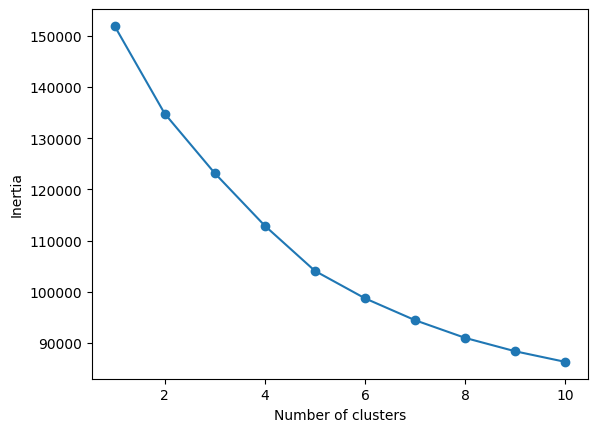

[151905.0, 134790.35248443947, 123153.33571754492, 112890.90073324484, 104079.94123897493, 98723.34371687284, 94452.4991087993, 91000.7291910714, 88386.01128241852, 86318.52924570866]


In [11]:
# Recalculate different cluster solutions and plot the Elbow Plot

def plot_elbow_curve(df, max_clusters=10):
    inertias = []
    for i in range(1, max_clusters + 1):
        model = KMeans(n_clusters=i)
        clusters = model.fit_predict(df)
        inertia = model.inertia_
        inertias.append(inertia)
        print(f"Cluster {i}, Inertia: {inertia}")

    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()

    return inertias


inertias = plot_elbow_curve(customers_scaled)
print(inertias)

There is no obvious "Elbow" with a strong discontinuity. However looking at the list of inertias for the cluster solutions, it seems that after the solution with 5 clusters, any additional cluster does not reduce the inertia as strongly anymore. Therefore we choose the five-cluster solution.

In [14]:
# Fit a model with 5 clusters

model = KMeans(n_clusters=5)
customers['CLUSTER'] = model.fit_predict(customers_scaled)

# Print the results

print("Clusters of first 5 cases:")
print(customers['CLUSTER']. head())
print('\n')
print("Distribution of clusters:")
print(customers['CLUSTER'].value_counts(normalize=True))
print('\n')
print("Model inertia: ", model.inertia_)
print("Centroid coordinates: " , model.cluster_centers_)
print("Number of iterations: ", model.n_iter_)
print("Number of features: ", model.n_features_in_)

Clusters of first 5 cases:
0    3
1    4
2    3
3    1
4    0
Name: CLUSTER, dtype: int32


Distribution of clusters:
0    0.342155
4    0.296139
3    0.194431
2    0.094994
1    0.072282
Name: CLUSTER, dtype: float64


Model inertia:  104078.81732360116
Centroid coordinates:  [[ 7.88682539e-02 -3.79205851e-01 -2.68502608e-02  2.85055874e-02
  -4.19543558e-01  7.26387541e-02  1.35786836e-01  4.98935540e-03
  -4.99799769e-01 -3.37898869e-01 -2.97631037e-01  3.71696563e-01
   9.16616337e-01 -7.98506854e-01 -2.82608874e-01]
 [-8.36062418e-02  2.26806190e-02  1.52067989e-01 -1.08835872e-02
  -1.18061460e-02 -8.35810671e-02 -7.74209745e-03 -5.04823066e-03
   6.19920813e-02  2.18822305e-02  4.83925281e-02 -5.66218812e-02
  -9.28213813e-01 -7.98506854e-01  3.53845931e+00]
 [-1.30134930e-01  3.58143918e-01 -8.04129027e-03 -4.39766421e-02
   1.73776791e-01 -1.01285294e-01 -1.06382517e+00 -1.49359384e-01
   6.55197559e-01  2.53449993e+00  1.73728114e+00 -3.94214818e-01
   2.45275304e-02  5.21031

## Analysing the results


In order to make sense of our clustering results, we will first plot the distributions of the categorical variables across the clusters and look for noteworthy patterns. In a second step, we will plot the meams of the numerical variables for each cluster, to get a comprehensive picture of the composition of each cluster.

We start wirh the categorical variables.

## Distribution of categorical variables by cluster

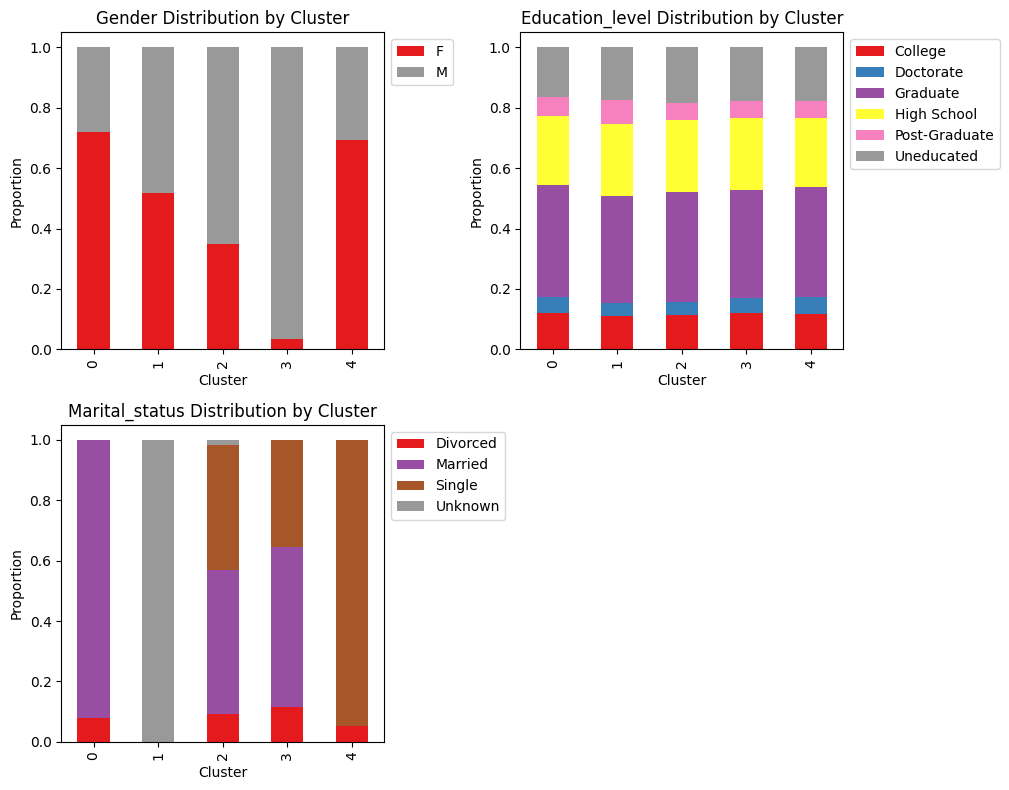

In [15]:
# Plot the distributions of the categroical variables over clusters

# Define columns and rows
n_cols = 2
n_rows = (len(cat_vars) + n_cols - 1) // n_cols  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

# Turn multicol-multirow matrix of subplot into just a row-vector for iteration
axes = axes.flatten()

# Loop through the categorical variables and create a  plot for each
for i, col in enumerate(cat_vars):

    cat_counts = pd.crosstab(customers['CLUSTER'], customers[col], normalize='index')  # Normalized counts

    cat_counts.plot(kind='bar', stacked=True, ax=axes[i], cmap='Set1')

    axes[i].set_title(f'{col.capitalize()} Distribution by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Proportion')

    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Legend outside the plots

# Remove any empty subplots (if there are fewer plots than grid spaces)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Regarding the gender distribution we find that the cluster solution has created mostly gender imbalanced clusters. While Cluster 1 seemes balanced, Cluster 0 and Cluster 4 have more women than men (7ß% Women), and Clusters 2 and 3 have more men than women (Cluster 2: 60% men; Cluster 3: 95% men).

All clusters have an identical distribution of education degrees.

They do, however, show marked differences regarding the distriutions of the marital status. While Cluster 0 almost exclusively represents married persons, Cluster 4 almost exclusively represents single persons. Additionally we can now see that Cluster 0 overwhelmingly seems to be composed of married women, while Cluster 4 contains the single women. Clusters 2 and 3 have a very similar distribtion of marital statuses, with the majority being male. Cluster 3 has a slightly higher share of married persons. Cluster 1, which is gender balanced, contains all persons with unknown marital status.

Roughly speking, the customer'S gender and marital status seem to play an important role, and more so for women than for men. We can see this because women are seperated into married and single clusters, which seems to affect their credit card use.

We now turn to the numerical variables.

## Mean values of numerical variables by cluster

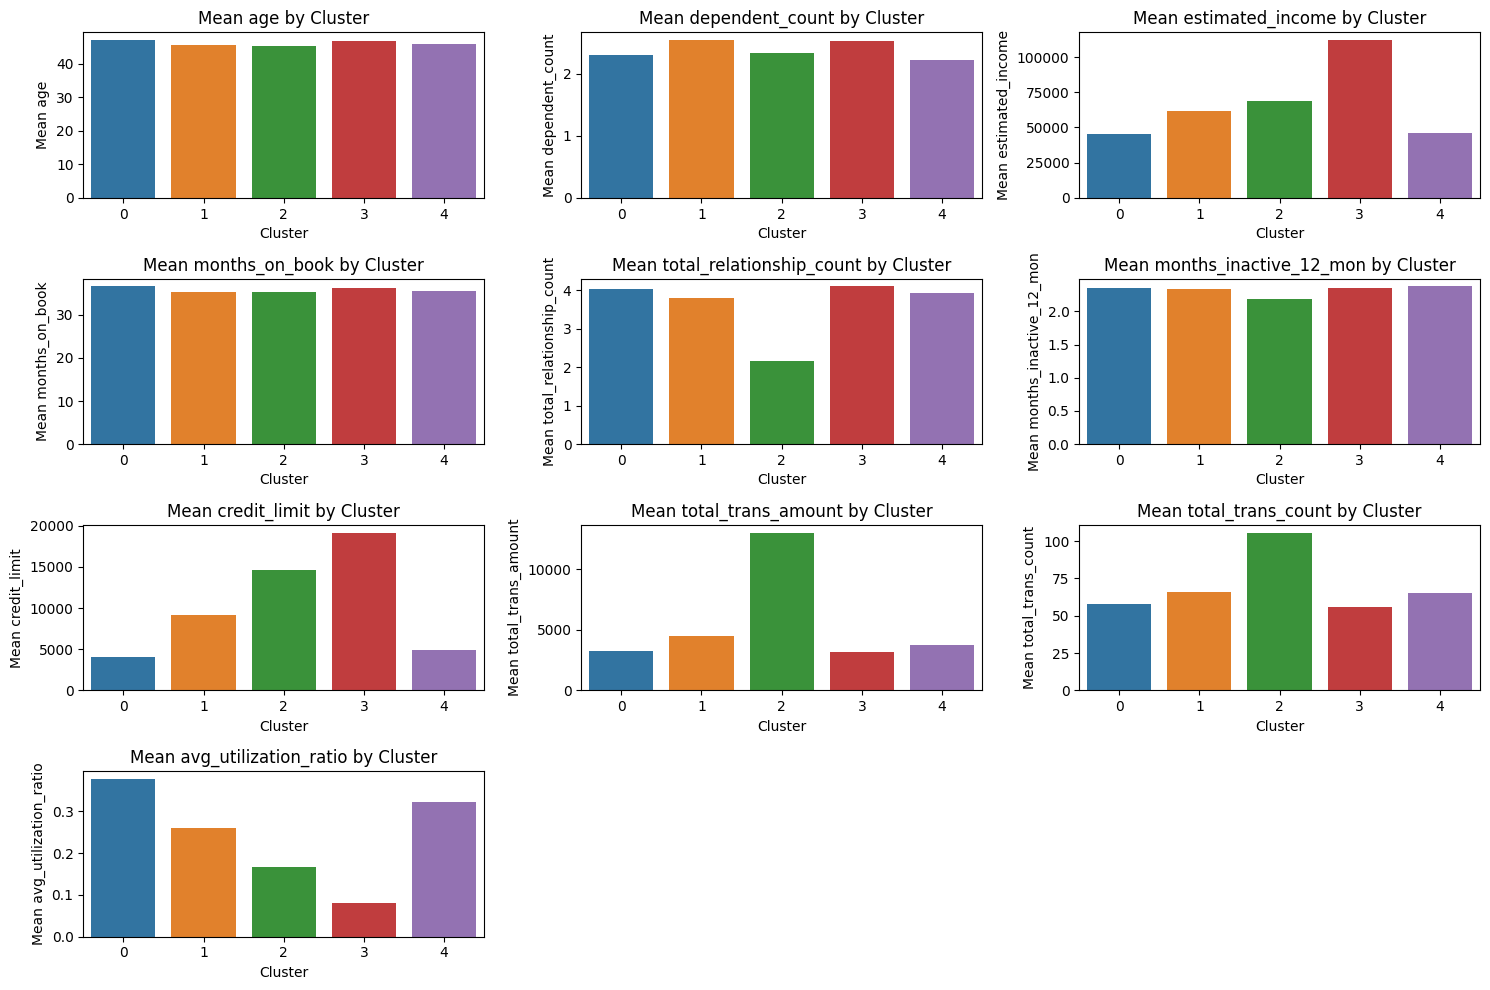

In [16]:
# Plotting the measn of the numerical variables by cluster

# Ignore customer_id
num_vars = num_vars[1:]

# Define columns and rows
n_cols = 3
n_rows = (len(num_vars) + n_cols - 1) // n_cols  # rows calculated based on cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Turn multicol-multirow matrix of subplot into just a row-vector for iteration
axes = axes.flatten()

# Loop through the numerical variables and create a  plot for each
for i, col in enumerate(num_vars):
    means = customers.groupby('CLUSTER')[col].mean()

    sns.barplot(x=means.index, y=means.values, ax=axes[i])

    axes[i].set_title(f'Mean {col} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Mean {col}')

# Remove any empty subplots (if there are fewer plots than grid spaces)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

These results show that the clusters are not differentiated by age, count of dependents, how long someone has been a customer or how long someone has been inactive. The mean of these variables is the same across clusters.

We do find, however, that mean income as well as the credit limit (both are closely correlated) play a role for the segmentation. The very male dominated cluster (Cluster 3) includes the customers with the highest average income and the highest average credit limit. The other male majority cluster (Cluster 2) ranks second with regard to mean incoem and credit limit. The gender balanced cluster (Cluster 1) has an intermediate position. The majority female clusters, Cluster 0 and Cluster 4, have the lowest mean income and credit limit.

The mean values of the other variables help us refine the picture further. We can see that Cluster 2 (male majority) stands out as haveing the lowest average level of contact with the company. But more importantly, the customers in this cluster stand out as having the highest average transfer amount and the highest average amount of total spending among all clusters. We could say, that this is a "Big spender" cluster, but at the same time the utilization ratio is low. So probably the usage behaviour here is that the credit card is being used for fewer but more expensive transactions, rather than many small transactions. In contrast, the most wealthy cluster (Cluster 3), is characterised by on average low transaction amounts and low absolute number of transactions. Also the general utilization ratio in this cluster is the lowest. Hence these seem to be people (overwhelmingly men) that rarely use their credit card and are more focused on saving money than spending it.

Looking at two female majority clusters we find that Cluster 0 (which has a high share of married women) is cahracterised by a low average income and credit limit, overall low transfer amounts, but average transfer counts and a very high utilization ration. Probably the customers in this cluster use their credit card to pay for day to day expenses, which are rather low amounts of spending per transaction. Lastly, the Cluster 4, which has a high share of single women, is very similar to the previous cluster in terms of transfer amounts and number of transfers. Here, also a high utilization ratio can be observed.

Lastly, Cluster 1, which has a balanced gender distribution, shows intermediate values on all of the variables. It seems to be a mixed cluster, which defies easy categorization.

Let us refine our result a bit more by plotting the highly correlated variables against each other and highlighting the cluster memberships.

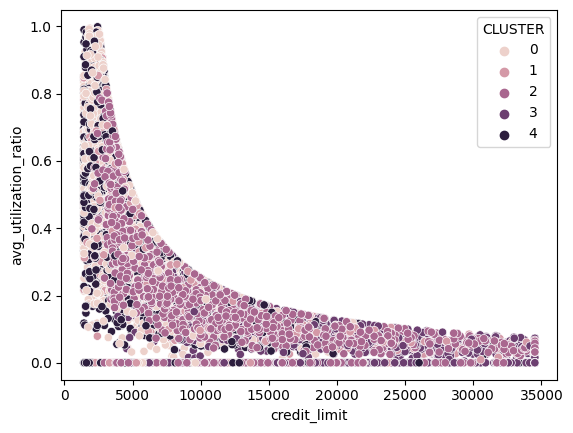

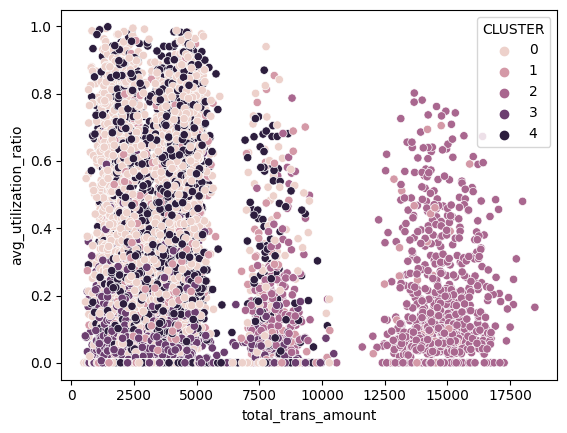

In [17]:
# Scatterplots of correlated variables and cluster membership

sns.scatterplot(data=customers, y='avg_utilization_ratio', x='credit_limit', hue='CLUSTER')
plt.show()

sns.scatterplot(data=customers, x='total_trans_amount', y='avg_utilization_ratio', hue='CLUSTER')
plt.show()

We just concentrate ehre on the correlations between `credit_limit` and `avg_utilization_ratio` (Plot 1) and `total_trans_amount`and `avg_utilization_ratio` (Plot 2). 

First of all, Plot 1 shows that the average utilization rate (i.e. how much is used of the credit limit) monotonically decreases with increasing credit limit. We can see that Clusters 0 and 4 are strongly represented in the part of the distribution with low credit limits and high utilization ratio. In contrast, Clusters 2 and 3 have much higher credit limits, but rarely make use of them.

A similar story is told by Plot 2. Again, we see that Clusters 0 and 4 with a high utilization ratio are strongly overrepresented among the transactions with low amounts. In contrast, Cluster 2 is almost exclusively representing the high sepding part of the distributions, with a somewhat higher concentration at lower utilization levels. The other clusters are mixed in the intemrdiate transfer amount levels.

## Relevant bsuiness insights

To conclude, we find that the segmentation of credit card usage is driven by income, which determines credit card limits, and this is highly impacted by gender. Furthermore, we can differentiate by marital status among female credit card holders. 

Athe business might be interested in tapping further into the more affulent customer base, it could make sense to focus on members of Cluster 2. Cluster 2 is charecterised by 60% of its members being male, 40% female, a farily high (but not the highest) income and frequent credit card use with sizeable amounts of spending. In contrast, members of Clusters 0 and 4 seem to have less disposable income and mostly use their credit cards for daily expenses, often utilizing their full limit.

The group that has most money to spend, is Cluster 3, which is over 90% male. This cluster is disproportionally wealthy, vut barely utilises their credit card. Potentially marketing could help increasing the spending of members in this cluster.